In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.insert(0, module_path)

import Double_Pendulum.Learning.autoencoders as autoencoders
import Double_Pendulum.robot_parameters as robot_parameters
import Double_Pendulum.dynamics as dynamics
import Double_Pendulum.transforms as transforms

import Double_Pendulum.normal_form as normal_form

import Plotting.pendulum_plot as pendulum_plot

import matplotlib
matplotlib.rcParams['font.family']   = 'serif'
matplotlib.rcParams['font.serif']    = ['Times New Roman']
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

from datetime import datetime

from functools import partial

%load_ext autoreload
%autoreload 2

In [2]:
rp = robot_parameters.LUMPED_PARAMETERS
rp["m0"] = 0.
plotter = pendulum_plot.Anim_plotter(rp)
print(rp)

k_spring = [4., 4.]
rest_angles = [0., torch.pi]

neural_net = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if neural_net:
	model = autoencoders.Autoencoder_double(rp).to(device)
	model_location = '../Double_Pendulum/Learning/Models/NN_optimal/NN_0.pth'
	model.load_state_dict(torch.load(model_location, weights_only=True))
else:
	model_location = "N/A"
	model = autoencoders.Analytic_transformer(rp)


model_cw = False

model_ana = autoencoders.Analytic_transformer(rp)

{'l0': 2.5, 'l1': 2.5, 'm0': 0.0, 'm1': 3.0, 'g': 9.81, 'xa': 2.0, 'ya': 5}


#### Some simple plotting functions

In [3]:
def plot_single_vs_time(single_list, dt, ylabel, title, ylim=None, log=False, ax=None):
	time = torch.linspace(0, (single_list.shape[0] - 1) * dt, single_list.shape[0]).numpy()
	single_np = single_list.cpu().numpy()

	if ax is None:
		ax = plt.gca()
	ax.plot(time, single_np, label=ylabel)
	ax.set_xlabel("Time (s)")
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	if ylim is not None:
		ax.set_ylim(ylim)
	if log:
		ax.set_yscale("log")
	ax.grid(True)
	ax.legend()


def plot_double_vs_time(double_list, dt, ylabel, title, ylim=None, log=False, ax=None):
	time = torch.linspace(0, (double_list.shape[0] - 1) * dt, double_list.shape[0]).numpy()
	double_np = double_list.cpu().numpy()

	if ax is None:
		ax = plt.gca()
	ax.plot(time, double_np[:, 0], label=ylabel + "0")
	ax.plot(time, double_np[:, 1], label=ylabel + "1")
	ax.set_xlabel("Time (s)")
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	if ylim is not None:
		ax.set_ylim(ylim)
	if log:
		ax.set_yscale("log")
	ax.grid(True)
	ax.legend()


def plot_quad_vs_time(quad_list, dt, ylabel, title, ylim=None, log=False, ax=None):
	time = torch.linspace(0, (quad_list.shape[0] - 1) * dt, quad_list.shape[0]).numpy()
	quad_np = quad_list.cpu().numpy()

	if ax is None:
		ax = plt.gca()
	ax.plot(time, quad_np[:, 0], label="Y")
	ax.plot(time, quad_np[:, 1], label="Y'")
	ax.plot(time, quad_np[:, 2], label="Y''")
	ax.plot(time, quad_np[:, 3], label="Y'''")
	ax.set_xlabel("Time (s)")
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	if ylim is not None:
		ax.set_ylim(ylim)
	if log:
		ax.set_yscale("log")
	ax.grid(True)
	ax.legend()


In [4]:
def plot_side_by_side(plot_configs):
	"""
	plot_configs: list of dicts, each containing:
	{
		"type": "single" | "double" | "quad",
		"data": torch.Tensor,
		"dt": float,
		"ylabel": str,
		"title": str,
		"ylim": tuple or None,
		"log": bool
	}
	"""
	n = len(plot_configs)
	fig, axes = plt.subplots(1, n, figsize=(4 * n, 2.5))

	if n == 1:
		axes = [axes]

	for i, config in enumerate(plot_configs):
		ax = axes[i]
		kwargs = {
			"dt": config["dt"],
			"ylabel": config["ylabel"],
			"title": config["title"],
			"ylim": config.get("ylim"),
			"log": config.get("log", False),
			"ax": ax
		}

		if config["type"] == "single":
			plot_single_vs_time(config["data"], **kwargs)
		elif config["type"] == "double":
			plot_double_vs_time(config["data"], **kwargs)
		elif config["type"] == "quad":
			plot_quad_vs_time(config["data"], **kwargs)
		else:
			raise ValueError(f"Unknown plot type: {config['type']}")

	plt.tight_layout()
	plt.show()


#### Define controller gains

In [5]:
K = torch.tensor([[45., 105., 45., 10.]]).to(device)
if normal_form.check_stable_gains(K, verbose = False):
	print("Gains are stable")

Gains are stable


#### Define desired conditions

In [6]:
#THE FOLLOWING COORDINATES RESULT IN STABLE Y_DES FOR k_spring = [0.1, 0.5]
#xy_des_real = torch.tensor([1.9090255, -2.5156569]).requires_grad_().to(device)
# THE FOLLOWING COORDINATES RESULT IN STABLE Y_DES FOR k_spring = [0.0, 0.5]
#xy_des_real = torch.tensor([1.9218631, -2.5156569]).requires_grad_().to(device)


xy_des_real = torch.tensor([1.9, -0.4]).requires_grad_().to(device)

q_d_des = torch.tensor([[0., 0.]]).requires_grad_().to(device)
q_des = transforms.inverse_kinematics(xy_des_real, rp, is_clockwise=model_cw).unsqueeze(0)
is_clockwise_des = transforms.check_clockwise(q_des.squeeze(0))

th_des = model.encoder_vmap(q_des)
th_d_des = (model.jacobian_enc(q_des) @ q_d_des.T).T

# Use this if you want to directly define a desired th_des
#th_des = torch.tensor([[8.08,  1.3]]).requires_grad_().to(device)
#th_d_des = torch.tensor([[0.,  0.]]).requires_grad_().to(device)

q_des_hat = model.decoder_vmap(th_des, clockwise=is_clockwise_des)
xy_des_hat = transforms.forward_kinematics(rp, q_des_hat.squeeze(0))[0]


print("xy_des:", xy_des_real)
print("q_des:", q_des)
print("q_des_hat:", q_des_hat)
print("xy_des_hat:", xy_des_hat[0].item(), xy_des_hat[1].item())
print("th_des", th_des)

xy_des: tensor([ 1.9000, -0.4000], device='cuda:0', grad_fn=<ToCopyBackward0>)
q_des: tensor([[-1.3795,  0.9645]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
q_des_hat: tensor([[-1.3795,  0.9645]], device='cuda:0', grad_fn=<StackBackward0>)
xy_des_hat: 1.8999998569488525 -0.39999818801879883
th_des tensor([[5.4009, 1.5523]], device='cuda:0', grad_fn=<StackBackward0>)


#### Calculate desired dynamics

In [7]:
J_h_inv_des = model.jacobian_dec(th_des, is_clockwise_des).squeeze(0)
J_h_inv_trans_des = torch.transpose(J_h_inv_des, 0, 1)

q_hat_des = model.decoder_vmap(th_des, is_clockwise_des)
q_d_hat_des = (model.jacobian_dec(th_des, clockwise=is_clockwise_des) @ th_d_des.T).T
#xy_des_est, _ = transforms.forward_kinematics(rp, q_hat_des[0])


M_q_des, C_q_des, G_q_des = dynamics.dynamical_matrices(rp, q_hat_des.squeeze(0), q_d_hat_des.squeeze(0))
G_q_des = dynamics.add_spring_force_G_q(rp, q_hat_des, G_q_des, k_spring, rest_angles)
A_q_des = dynamics.input_matrix(rp, q_des.squeeze(0))

M_th_des, C_th_des, G_th_des = transforms.transform_dynamical_from_inverse(M_q_des, C_q_des, G_q_des, th_des, th_d_des, J_h_inv_des, J_h_inv_trans_des)
A_th_des = transforms.transform_input_matrix_from_inverse_trans(A_q_des, J_h_inv_trans_des)

Y_des_u = normal_form.calculate_Y(th_des, th_d_des, M_th_des, G_th_des, device)
Y_des = torch.tensor([[Y_des_u[0,0]], [0], [0], [0]]).to(device)

alpha_des, beta_des = normal_form.calculate_alpha_beta(th_des, th_d_des, M_th_des, G_th_des, A_th_des, Y_des)

print("M_th des:\n", M_th_des)
print("G_th des:\n", G_th_des)

print("Y_des_u:\n", Y_des_u)
print("Y_des:\n", Y_des)

print("alpha_des:", alpha_des.item())
print("beta_des:", beta_des.item())

M_th des:
 tensor([[3.0000e+00, 1.0967e-05],
        [1.1444e-05, 8.7510e+01]], device='cuda:0', grad_fn=<MmBackward0>)
G_th des:
 tensor([[-32.2514],
        [ -1.0535]], device='cuda:0', grad_fn=<MmBackward0>)
Y_des_u:
 tensor([[1.5523],
        [0.0000],
        [0.0120],
        [0.0000]], device='cuda:0')
Y_des:
 tensor([[1.5523],
        [0.0000],
        [0.0000],
        [0.0000]], device='cuda:0')
alpha_des: -1.1786001920700073
beta_des: -0.03654414787888527


#### Define start conditions

In [8]:
#xy_start = torch.tensor([2, -1.9]).requires_grad_().to(device)
xy_start = xy_des_real * 1.15
q_d_start = torch.tensor([[0., 0.]]).requires_grad_().to(device)
q_dd_start = torch.tensor([[0., 0.]]).requires_grad_().to(device)

q_start = transforms.inverse_kinematics(xy_start, rp, is_clockwise=model_cw).unsqueeze(0)
is_clockwise_start = transforms.check_clockwise(q_start.squeeze(0))

th_start = model.encoder_vmap(q_start)
th_d_start = (model.jacobian_enc(q_start) @ q_d_start.T).T

print("xy_start:", xy_start)
print("q_start:", q_start)
print("th_start:", th_start)

xy_start: tensor([ 2.1850, -0.4600], device='cuda:0', grad_fn=<MulBackward0>)
q_start: tensor([[-1.3154,  0.9004]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
th_start: tensor([[5.4631, 1.6047]], device='cuda:0', grad_fn=<StackBackward0>)


#### Calculate starting dynamics

In [9]:
J_h_inv_start = model.jacobian_dec(th_start, is_clockwise_start).squeeze(0)
J_h_inv_trans_start = torch.transpose(J_h_inv_start, 0, 1)

q_hat_start = model.decoder_vmap(th_start, is_clockwise_start)
q_d_hat_start = (model.jacobian_dec(th_start, clockwise=is_clockwise_start) @ th_d_start.T).T

M_q_start, C_q_start, G_q_start = dynamics.dynamical_matrices(rp, q_hat_start.squeeze(0), q_d_hat_start.squeeze(0))
G_q_start = dynamics.add_spring_force_G_q(rp, q_hat_start, G_q_start, k_spring, rest_angles)
A_q_start = dynamics.input_matrix(rp, q_hat_start.squeeze(0))

M_th_start, C_th_start, G_th_start = transforms.transform_dynamical_from_inverse(M_q_start, C_q_start, G_q_start, th_start, th_d_start, J_h_inv_start, J_h_inv_trans_start)
A_th_start = transforms.transform_input_matrix_from_inverse_trans(A_q_start, J_h_inv_trans_start)

Y_start = normal_form.calculate_Y(th_start, th_d_start, M_th_start, G_th_start, device)
v_start = normal_form.calculate_v(Y_start, Y_des, K)
alpha_start, beta_start = normal_form.calculate_alpha_beta(th_start, th_d_start, M_th_start, G_th_start, A_th_start, Y_start)
u_start = normal_form.calculate_u(alpha_start, beta_start, v_start)
y_iv_start = normal_form.calculate_y_iv(alpha_start, beta_start, u_start)

print("v_start:", v_start)
print("u_start:", u_start)
print("yiv_start:", y_iv_start)

print("M_th start:\n", M_th_start)
print("G_th start:\n", G_th_start)
print("A_th start:\n", A_th_start)

print("Y_start:", Y_start)

print("alpha_start:", alpha_start.item())
print("beta_start:", beta_start.item())

v_start: tensor([[0.6467]], device='cuda:0')
u_start: tensor([[-50.2556]], device='cuda:0', grad_fn=<MulBackward0>)
yiv_start: tensor([[0.6467]], device='cuda:0', grad_fn=<AddBackward0>)
M_th start:
 tensor([[3.0000e+00, 1.0729e-05],
        [1.0490e-05, 8.9537e+01]], device='cuda:0', grad_fn=<MmBackward0>)
G_th start:
 tensor([[-31.8158],
        [  5.9773]], device='cuda:0', grad_fn=<MmBackward0>)
A_th start:
 tensor([[1.0000e+00],
        [1.7881e-06]], device='cuda:0', grad_fn=<MmBackward0>)
Y_start: tensor([[ 1.6047],
        [ 0.0000],
        [-0.0668],
        [ 0.0000]], device='cuda:0')
alpha_start: -0.8673681020736694
beta_start: -0.03012789599597454


### Sim in $\theta$-space

In [10]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

th_series_thsim, th_d_series_thsim, th_dd_series_thsim = torch.empty((0,2)).to(device), torch.empty((0,2)).to(device), torch.empty((0,2)).to(device)
q_series_thsim, q_d_series_thsim, q_dd_series_thsim = torch.empty((0,2)).to(device), torch.empty((0,2)).to(device), torch.empty((0,2)).to(device)
Y_series_thsim = torch.empty((0,4)).to(device)
v_series_thsim = torch.empty((0,1)).to(device)
u_series_thsim = torch.empty((0,1)).to(device)
alpha_beta_series_thsim = torch.empty((0,2)).to(device)
alpha_beta_true_series_thsim = torch.empty((0,2)).to(device)


dt = 0.01
t_end = 15
t_series = torch.arange(0, t_end, dt)

th = th_start
th_d = th_d_start

beta_threshold = 0.01
alpha_treshold = 100

is_clockwise = transforms.check_clockwise(q_start.squeeze(0))

for t in torch.arange(0, t_end, dt):
	t_string = "Time: [" + str(t.item().__round__(3)) + "/" + str(t_end) + ".0]"
	print(t_string, end='\r', flush=True)

	#print("th:", th)
	#print("th_d:", th_d)

	q_hat = model.decoder_vmap(th, clockwise=model_cw)
	q_d_hat = (model.jacobian_dec(th) @ th_d.T).T
	
	""" Obtain Jacobian, dynamical matrices"""
	
	J_h_inv = model.jacobian_dec(th, is_clockwise).squeeze(0)
	J_h_inv_trans = torch.transpose(J_h_inv, 0, 1)

	M_q_est, C_q_est, G_q_est = dynamics.dynamical_matrices(rp, q_hat.squeeze(0), q_d_hat.squeeze(0))
	G_q_est = dynamics.add_spring_force_G_q(rp, q_hat, G_q_est, k_spring, rest_angles)
	A_q_est = dynamics.input_matrix(rp, q_hat.squeeze(0))


	""" Feed-forward simulation of the system, not on real dynamics """
	M_th, C_th, G_th = transforms.transform_dynamical_from_inverse(M_q_est, C_q_est, G_q_est, th, th_d, J_h_inv, J_h_inv_trans)
	A_th = transforms.transform_input_matrix_from_inverse_trans(A_q_est, J_h_inv_trans)

	Y = normal_form.calculate_Y(th, th_d, M_th, G_th, device)
	alpha_true, beta_true = normal_form.calculate_alpha_beta(th, th_d, M_th, G_th, A_th, Y)

	"""
	alpha = torch.clamp(alpha_true, min = -alpha_treshold, max = alpha_treshold)
	if beta_true > 0 and beta_true < beta_threshold:
		beta = beta_threshold
	elif beta_true < 0 and beta_true > -beta_threshold:
		beta = -beta_threshold
	else:
		beta = beta_true
	"""
	alpha, beta = alpha_true, beta_true
	#alpha, beta = alpha_des, beta_des

	v = normal_form.calculate_v(Y, Y_des, K)
	u = normal_form.calculate_u(alpha, beta, v)

	if True:
		print("t: t")
		print("q_hat:", q_hat[0,0].item(), q_hat[0,1].item())
		print("th:", th[0,0].item(), th[0,1].item())
		print("th_d:", th_d[0,0].item(), th_d[0,1].item())
		#print("alpha:", alpha.item())
		#print("beta:", beta.item())
		print("Y:", Y)
		print("v:", v.item())
		print("u:", u.item())




	""" Update the real system and apply latent control input. """

	
	tau_th = A_th * u
	th_dd = (torch.pinverse(M_th) @ (tau_th - G_th)).T
	th_d = th_d + th_dd * dt
	th = th + th_d * dt

	q_est = model.decoder_vmap(th, clockwise=is_clockwise)
	q_est = transforms.wrap_to_pi(q_est)
	q_d_est = (model.jacobian_dec(th, clockwise=is_clockwise) @ th_d.T).T

	print("tau_th:", tau_th)
	print("th_d:", th_d)
	print("th:", th)
	print("q_est:", q_est)
	print("q_d_est:", q_d_est)
	print("\n")

	""" Store data for plotting """

	th_series_thsim = torch.cat((th_series_thsim, th.detach()), dim=0)
	th_d_series_thsim = torch.cat((th_d_series_thsim, th_d.detach()), dim=0)
	th_dd_series_thsim = torch.cat((th_dd_series_thsim, th_dd.detach()), dim=0)

	q_series_thsim = torch.cat((q_series_thsim, q_est.detach()), dim=0)
	q_d_series_thsim = torch.cat((q_d_series_thsim, q_d_est.detach()), dim=0)

	v_series_thsim = torch.cat((v_series_thsim, v.detach()), dim=0)
	u_series_thsim = torch.cat((u_series_thsim, u.detach()), dim=0)
	Y_series_thsim = torch.cat((Y_series_thsim, Y.detach().T))
	alpha_beta_series_thsim = torch.cat((alpha_beta_series_thsim, torch.tensor([[alpha.detach(), beta.detach()]]).to(device)))
	alpha_beta_true_series_thsim = torch.cat((alpha_beta_true_series_thsim, torch.tensor([[alpha_true.detach(), beta_true.detach()]]).to(device)))
	#print("")

	if torch.isnan(th[0,0]):
		break

	
	


t: t: [0.0/15.0]
q_hat: -1.3153539896011353 0.9003612995147705
th: 5.463134288787842 1.6046662330627441
th_d: 0.0 0.0
Y: tensor([[ 1.6047],
        [ 0.0000],
        [-0.0668],
        [ 0.0000]], device='cuda:0')
v: 0.6467268466949463
u: -50.25558090209961
tau_th: tensor([[-5.0256e+01],
        [-8.9864e-05]], device='cuda:0', grad_fn=<MulBackward0>)
th_d: tensor([[-0.0615, -0.0007]], device='cuda:0', grad_fn=<AddBackward0>)
th: tensor([[5.4625, 1.6047]], device='cuda:0', grad_fn=<AddBackward0>)
q_est: tensor([[-1.3151,  0.9007]], device='cuda:0', grad_fn=<SubBackward0>)
q_d_est: tensor([[0.0223, 0.0304]], device='cuda:0', grad_fn=<PermuteBackward0>)


t: t: [0.01/15.0]
q_hat: -1.315131425857544 0.9006655216217041
th: 5.462519645690918 1.6046595573425293
th_d: -0.06146605685353279 -0.0006675826734863222
Y: tensor([[ 1.6047e+00],
        [-6.6758e-04],
        [-6.6708e-02],
        [ 6.4693e-03]], device='cuda:0')
v: 0.650197446346283
u: -50.364349365234375
tau_th: tensor([[-5.0364e+

KeyboardInterrupt: 

#### Sim in q-space

In [23]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

th_series_qsim, th_d_series_qsim = torch.empty((0,2)).to(device), torch.empty((0,2)).to(device)
q_series_qsim, q_d_series_qsim, q_dd_series_qsim = torch.empty((0,2)).to(device), torch.empty((0,2)).to(device), torch.empty((0,2)).to(device)
Y_series_qsim = torch.empty((0,4)).to(device)
v_series_qsim = torch.empty((0,1)).to(device)
u_series_qsim = torch.empty((0,1)).to(device)
alpha_beta_series_qsim = torch.empty((0,2)).to(device)
alpha_beta_true_series_qsim = torch.empty((0,2)).to(device)


dt = 0.01
t_end = 15
t_series = torch.arange(0, t_end, dt)

q_real = q_start
q_d_real = q_d_start

is_clockwise = transforms.check_clockwise(q_start.squeeze(0))
fix_q = True
model_shifting = True

for t in torch.arange(0, t_end, dt):
	t_string = "Time: [" + str(t.item().__round__(3)) + "/" + str(t_end) + ".0]"
	print(t_string, end='\r', flush=True)

	#is_clockwise = transforms.check_clockwise(q_real.squeeze(0))
	if fix_q and model_cw != is_clockwise:
		print("fixing value to", "clockwise" if model_cw else "counterclockwise")
		q = transforms.flip_q(rp, q_real.squeeze(0), model_cw).unsqueeze(0)
		q_d = transforms.flip_q_d(rp, q_real.squeeze(0), q_d_real, model_cw)
	else:
		q = q_real
		q_d = q_d_real

	if model_shifting:
		q = transforms.shift_q(q, clockwise=model_cw)
	th = model.encoder_vmap(q)
	th_d = (model.jacobian_enc(q) @ q_d.T).T
	
	q = model.decoder_vmap(th, clockwise=model_cw)
	q_d = (model.jacobian_dec(th) @ th_d.T).T
	
	""" Obtain Jacobian, dynamical matrices"""
	
	J_h = model.jacobian_enc(q, is_clockwise).squeeze(0)
	J_h_trans = torch.transpose(J_h, 0, 1)

	J_h_inv = model.jacobian_dec(th, is_clockwise).squeeze(0)
	J_h_inv_trans = torch.transpose(J_h_inv, 0, 1)

	M_q_est, C_q_est, G_q_est = dynamics.dynamical_matrices(rp, q.squeeze(0), q_d.squeeze(0))
	G_q_est = dynamics.add_spring_force_G_q(rp, q, G_q_est, k_spring, rest_angles)
	A_q_est = dynamics.input_matrix(rp, q.squeeze(0))

	M_th, C_th, G_th = transforms.transform_dynamical_from_inverse(M_q_est, C_q_est, G_q_est, th, th_d, J_h_inv, J_h_inv_trans)
	A_th = transforms.transform_input_matrix_from_inverse_trans(A_q_est, J_h_inv_trans)

	Y = normal_form.calculate_Y(th, th_d, M_th, G_th, device)
	alpha_true, beta_true = normal_form.calculate_alpha_beta(th, th_d, M_th, G_th, A_th, Y)
	#alpha = torch.clamp(alpha_true, min = -alpha_des, max = alpha_des)
	#beta = beta_true.sign() * torch.clamp(beta_true.abs(), min = beta_des)
	alpha, beta = alpha_true, beta_true

	v = normal_form.calculate_v(Y, Y_des, K)
	u = normal_form.calculate_u(alpha, beta, v)
	#y_iv = normal_form.calculate_y_iv(alpha, beta, u)
	#print("y_iv:", y_iv.item())

	if True:
		print("t: t")
		print("q_est:", q[0,0].item(), q[0,1].item())
		print("th:", th[0,0].item(), th[0,1].item())
		print("th_d:", th_d[0,0].item(), th_d[0,1].item())
		print("Y:", Y)
		#print("Y_des:", Y_des)
		print("v:", v.item())
		print("u:", u.item())



	""" Update the real system and apply latent control input. """

	
	M_q_real, C_q_real, G_q_real = dynamics.dynamical_matrices(rp, q_real.squeeze(0), q_d_real.squeeze(0))
	G_q_real = dynamics.add_spring_force_G_q(rp, q_real, G_q_real, k_spring, rest_angles)
	A_q_real = dynamics.input_matrix(rp, q_real.squeeze(0))
	
	tau_q_real = A_q_real * u
	q_dd_real = (torch.pinverse(M_q_real) @ (tau_q_real - C_q_real @ ((q_d_real).T) - G_q_real)).T
	q_d_real = q_d_real + q_dd_real * dt
	q_real = q_real + q_d_real * dt
	q_real = transforms.wrap_to_pi(q_real)

	#q_real_shifted = transforms.shift_q(q_real, clockwise=model_cw)
	th = model.encoder_vmap(q_real)#_shifted)
	q_est = model.decoder_vmap(th, clockwise=transforms.check_clockwise(q_real.squeeze(0)))
	q_est = transforms.wrap_to_pi(q_est)
	th_d = (model.jacobian_enc(q_real) @ q_d_real.T).T
	q_d_est = (model.jacobian_dec(th, clockwise=is_clockwise) @ th_d.T).T

	print("tau_q:", tau_q_real)
	print("th_d:", th_d)
	print("th:", th)
	print("q_real:", q_real)
	print("q_d_real:", q_d_real)
	print("q_est:", q_est)
	print("q_d_est:", q_d_est)
	print("C_q_real:", C_q_real)
	print("\n")
	

	""" Store data for plotting """

	th_series_qsim = torch.cat((th_series_qsim, th.detach()), dim=0)
	th_d_series_qsim = torch.cat((th_d_series_qsim, th_d.detach()), dim=0)

	q_series_qsim = torch.cat((q_series_qsim, q_est.detach()), dim=0)
	q_d_series_qsim = torch.cat((q_d_series_qsim, q_d_est.detach()), dim=0)

	v_series_qsim = torch.cat((v_series_qsim, v.detach()), dim=0)
	u_series_qsim = torch.cat((u_series_qsim, u.detach()), dim=0)
	Y_series_qsim = torch.cat((Y_series_qsim, Y.detach().T))
	alpha_beta_series_qsim = torch.cat((alpha_beta_series_qsim, torch.tensor([[alpha.detach(), beta.detach()]]).to(device)))
	alpha_beta_true_series_qsim = torch.cat((alpha_beta_true_series_qsim, torch.tensor([[alpha_true.detach(), beta_true.detach()]]).to(device)))
	#print("")

	if torch.isnan(th[0,0]):
		break

	
	


t: t: [0.0/15.0]
q_est: -1.3153539896011353 0.9003612995147705
th: 5.463134288787842 1.6046662330627441
th_d: 0.0 0.0
Y: tensor([[ 1.6047],
        [ 0.0000],
        [-0.0668],
        [ 0.0000]], device='cuda:0')
v: 0.6467268466949463
u: -50.25558090209961
tau_q: tensor([[27.6109],
        [81.3518]], device='cuda:0', grad_fn=<MulBackward0>)
th_d: tensor([[-0.0615, -0.0007]], device='cuda:0', grad_fn=<PermuteBackward0>)
th: tensor([[5.4625, 1.6047]], device='cuda:0', grad_fn=<StackBackward0>)
q_real: tensor([[-1.3151,  0.9007]], device='cuda:0', grad_fn=<SubBackward0>)
q_d_real: tensor([[0.0223, 0.0304]], device='cuda:0', grad_fn=<AddBackward0>)
q_est: tensor([[-1.3151,  0.9007]], device='cuda:0', grad_fn=<SubBackward0>)
q_d_est: tensor([[0.0223, 0.0304]], device='cuda:0', grad_fn=<PermuteBackward0>)
C_q_real: tensor([[0., -0.],
        [0., 0.]], device='cuda:0', grad_fn=<CatBackward0>)


t: t: [0.01/15.0]
q_est: -1.3151311874389648 0.9006655216217041
th: 5.46251916885376 1.60465955

## Collocated sim for visualization

In [24]:
# Controller gains in theta-space
Kp = torch.tensor([[100., 0.], 
				   [0., 0.]]).to(device)
Kd = torch.tensor([[40., 0.], 
				   [0., 0.]]).to(device)

In [25]:
def desired_conditions(xy_des, model):
	q_des = transforms.inverse_kinematics(xy_des, rp, is_clockwise=model_cw).unsqueeze(0)
	q_d_des = torch.tensor([[0., 0.]]).requires_grad_().to(device)

	is_clockwise_des = transforms.check_clockwise(q_des.squeeze(0))

	th_des_ana = model_ana.encoder_vmap(q_des)
	th_d_des_ana = (model_ana.jacobian_enc(q_des) @ q_d_des.T).T

	th_des_est = model.encoder_vmap(q_des)
	th_d_des_est = (model.jacobian_enc(q_des) @ q_d_des.T).T

	q_des_est = model.decoder_vmap(th_des_est, is_clockwise_des)
	q_d_des_est = (model.jacobian_dec(th_des_est, clockwise=is_clockwise_des) @ th_d_des_est.T).T
	xy_des_est, _ = transforms.forward_kinematics(rp, q_des_est[0])

	#print("xy_des:", xy_des.detach().cpu().numpy())
	#print("th_des_ana:", th_des_ana.detach().cpu().numpy()[0])

	return (q_des, q_d_des, is_clockwise_des, th_des_ana, th_d_des_ana, 
		 	th_des_est, th_d_des_est, q_des_est, q_d_des_est, xy_des_est)

In [26]:
def start_conditions(xy_start, model):
	q_start = transforms.inverse_kinematics(xy_start, rp, is_clockwise=model_cw).unsqueeze(0)
	q_d_start = torch.tensor([[0., 0.]]).requires_grad_().to(device)
	q_dd_start = torch.tensor([[0., 0.]]).requires_grad_().to(device)

	is_clockwise_start = transforms.check_clockwise(q_start.squeeze(0))

	th_start_est = model.encoder_vmap(q_start)
	th_d_start_est = (model.jacobian_enc(q_start) @ q_d_start.T).T

	th_start_ana = model_ana.encoder_vmap(q_start)
	th_d_start_ana = (model_ana.jacobian_enc(q_start) @ q_d_start.T).T

	q_start_est = model.decoder_vmap(th_start_est, is_clockwise_start)
	q_d_start_est = (model.jacobian_dec(th_start_est, clockwise=is_clockwise_start) @ th_d_start_est.T).T
	xy_start_est, _ = transforms.forward_kinematics(rp, q_start_est[0])

	#print("xy_start:", xy_start.detach().cpu().numpy())
	#print("th_start_ana:", th_start_ana.detach().cpu().numpy()[0])

	return (q_start, q_d_start, q_dd_start, is_clockwise_start, th_start_est, th_d_start_est, 
		 	th_start_ana, th_d_start_ana, q_start_est, q_d_start_est, xy_start_est)

In [27]:
def sim_collocated_nn(xy_start, xy_des, timestamp, model_nn, C_damp):

	(q_des, q_d_des, is_clockwise_des, th_des_ana, th_d_des_ana, 
		th_des_est, th_d_des_est, q_des_est, q_d_des_est, xy_des_est) = desired_conditions(xy_des, model_nn)

	(q_start, q_d_start, q_dd_start, is_clockwise_start, th_start_est, th_d_start_est, 
		th_start_ana, th_d_start_ana, q_start_est, q_d_start_est, xy_start_est) = start_conditions(xy_start, model_nn)
	

	num_steps = int(t_end / dt)
	th_series, th_d_series      = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	th_ana_series, th_d_ana_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	q_hat_series, q_d_hat_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	q_real_series, q_d_real_series, q_dd_real_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	u_series = torch.empty((num_steps, 1)).to(device)
	tau_q_series = torch.empty((num_steps, 2)).to(device)

	# Define starting conditions
	th = th_start_est
	th_d = th_d_start_est

	q_hat = q_start_est
	q_d_hat = q_d_start_est

	q_real, q_d_real, q_dd_real = q_start, q_d_start, q_dd_start

	is_clockwise = transforms.check_clockwise(q_start.squeeze(0))



	for i, t in enumerate(torch.arange(0, t_end, dt)):
		t_string = "Time: [" + str(t.item().__round__(3)) + "/" + str(t_end) + ".0]"
		if torch.allclose(t, torch.floor(t)) and torch.floor(t)%5 == 0:
			print(t_string)

		is_clockwise = transforms.check_clockwise(q_real.squeeze(0))
		if model_cw != is_clockwise:
			print("fixing value to", "clockwise" if model_cw else "counterclockwise")
			q = transforms.flip_q(rp, q_real.squeeze(0), model_cw).unsqueeze(0)
			q_d = transforms.flip_q_d(rp, q_real.squeeze(0), q_d_real, model_cw)
		else:
			q = q_real
			q_d = q_d_real

		th = model_nn.encoder_vmap(q)
		th_d = (model_nn.jacobian_enc(q) @ q_d.T).T
		
		q_hat = model_nn.decoder_vmap(th, clockwise=model_cw)
		q_d_hat = (model_nn.jacobian_dec(th) @ th_d.T).T

		is_clockwise = transforms.check_clockwise(q_hat.squeeze(0))

		""" Obtain Jacobian, dynamical matrices"""
		
		J_h_inv = model_nn.jacobian_dec(th, is_clockwise).squeeze(0)
		J_h_inv_trans = torch.transpose(J_h_inv, 0, 1)

		M_q_est, C_q_est, G_q_est = dynamics.dynamical_matrices(rp, q_hat.squeeze(0), q_d_hat.squeeze(0))
		A_q_est = dynamics.input_matrix(rp, q_hat.squeeze(0))


		# Compute the M_th Jacobian
		calc_M_th_partial = partial(transforms.calc_M_th_from_th, rp=rp, model=model_nn, model_cw=False)
		dM_th = torch.autograd.functional.jacobian(calc_M_th_partial, th).squeeze()

		""" Feed-forward simulation of the system, not on real dynamics """

		M_th = transforms.transform_M_th(M_q_est, J_h_inv, J_h_inv_trans)
		C_th = transforms.transform_C_th(dM_th, th_d)
		G_th = transforms.transform_G_th(G_q_est, J_h_inv_trans)

		A_th = transforms.transform_input_matrix_from_inverse_trans(A_q_est, J_h_inv_trans)

		u = torch.pinverse(A_th) @ ((Kp @ (th_des_est - th).T + Kd @ (th_d_des_est - th_d).T))
		u = u + torch.pinverse(A_th) @ G_th

		""" Update the real system and apply latent control input. """

		M_q_real, C_q_real, G_q_real = dynamics.dynamical_matrices(rp, q_real.squeeze(0), q_d_real.squeeze(0))
		A_q_real = dynamics.input_matrix(rp, q_real.squeeze(0))

		tau_q_real = A_q_real * u
		q_dd_real = (torch.pinverse(M_q_real) @ (tau_q_real - C_q_real @ ((q_d_real).T) - (C_damp @ ((q_d_real).T)) - G_q_real)).T
		q_d_real = q_d_real + q_dd_real * dt
		q_real = q_real + q_d_real * dt
		q_real = transforms.wrap_to_pi(q_real)
		
		th = model_nn.encoder_vmap(q_real)
		q_hat = model_nn.decoder_vmap(th, clockwise=transforms.check_clockwise(q_real.squeeze(0)))
		q_hat = transforms.wrap_to_pi(q_hat)
		th_d = (model_nn.jacobian_enc(q_real) @ q_d_real.T).T
		q_d_hat = (model_nn.jacobian_dec(th, clockwise=is_clockwise) @ th_d.T).T

		th_ana = model_ana.encoder_vmap(q_real)
		th_d_ana = (model_ana.jacobian_enc(q_real) @ q_d_real.T).T



		""" Store data for plotting """

		th_series[i] = th.detach()
		th_d_series[i] = th_d.detach()

		th_ana_series[i] = th_ana.detach()
		th_d_ana_series[i] = th_d_ana.detach()

		q_real_series[i] = q_real.detach()
		q_d_real_series[i] = q_d_real.detach()
		q_dd_real_series[i] = q_dd_real.detach()

		q_hat_series[i] = q_hat.detach()
		q_d_hat_series[i] = q_d_hat.detach()

		u_series[i] = u.detach()
		tau_q_series[i] = tau_q_real.T.detach()


	xy_real_series = torch.empty(q_real_series.size()).to(device)
	xy_hat_series = torch.empty(q_real_series.size()).to(device)

	for i, (q_real, q_hat) in enumerate(zip(q_real_series, q_hat_series)):
		xy_real, _ = transforms.forward_kinematics(rp, q_real)
		xy_real_series[i] = xy_real.unsqueeze(0)
		xy_hat, _ = transforms.forward_kinematics(rp, q_hat)
		xy_hat_series[i] = xy_hat.unsqueeze(0)

	nn_sim_data = {
		"th_s": th_series,
		"th_d_s": th_d_series,
		"th_ana_s": th_ana_series,
		"th_d_ana_s": th_d_ana_series,
		"q_real_s": q_real_series,
		"q_d_real_s": q_d_real_series,
		"q_dd_real_s": q_dd_real_series,
		"q_hat_s": q_hat_series,
		"q_d_hat_s": q_d_hat_series,
		"xy_real_s": xy_real_series,
		"xy_hat_s": xy_hat_series,
		"u_s": u_series,
		"tau_q_s": tau_q_series
	}

	return (nn_sim_data, q_des, q_start, th_des_ana, th_start_ana)

C_damp = torch.tensor([[0., 0.], [0., 0.]]).to(device)

model_nn = autoencoders.Autoencoder_double(rp).to(device)
model_location = '../Double_Pendulum/Learning/Models/NN_optimal/NN_0.pth'
model_nn.load_state_dict(torch.load(model_location, weights_only=True))



nns_data, q_des, q_start, th_des_ana, th_start_ana = sim_collocated_nn(xy_start, xy_des_real, timestamp, model_nn, C_damp)

Time: [0.0/15.0]
Time: [5.0/15.0]
Time: [10.0/15.0]


In [28]:
q_series_collocated = nns_data["q_real_s"]
th_series_collocated = nns_data["th_ana_s"]

In [29]:
xy_real_series_qsim = torch.empty((0,2)).to(device)
#xy_est_series = torch.empty((0,2)).to(device)

for q_real_qsim in q_series_qsim:
	xy_real_qsim, _ = transforms.forward_kinematics(rp, q_real_qsim)
	xy_real_series_qsim = torch.cat((xy_real_series_qsim, xy_real_qsim.unsqueeze(0)))

xy_real_series_collocated = torch.empty((0,2)).to(device)
#xy_est_series = torch.empty((0,2)).to(device)

for q_real_collocated in q_series_collocated:
	xy_real_collocated, _ = transforms.forward_kinematics(rp, q_real_collocated)
	xy_real_series_collocated = torch.cat((xy_real_series_collocated, xy_real_collocated.unsqueeze(0)))

In [12]:
xy_real_series_thsim = torch.empty((0,2)).to(device)

for q_real_thsim in q_series_thsim:
	xy_real_thsim, _ = transforms.forward_kinematics(rp, q_real_thsim)
	xy_real_series_thsim = torch.cat((xy_real_series_thsim, xy_real_thsim.unsqueeze(0)))

NameError: name 'q_series_thsim' is not defined

In [30]:
save_dir = f"non-collocated_results/simulation_{timestamp}"
os.makedirs(save_dir, exist_ok=True)


metadata = {
	"timestamp": timestamp,
	"Learned transform": neural_net,
	"Model location": model_location,
	"Model clockwise": model_cw,
	"Model shifting": model_shifting, 
	"Spring stiffness": k_spring,
	"normal_form gains": [K[0, 0].item(),K[0, 1].item(),K[0, 2].item(),K[0, 3].item()],
	"Actuator location": {"x_a": rp["xa"], "y_a": rp["ya"]},
	"xy start": {"x": xy_start[0].item(), "y": xy_start[1].item()},
	"Time step": dt,
	"Sim time": t_end,
}

metadata_path = os.path.join(save_dir, "metadata.json")
with open(metadata_path, "w") as f:
	json.dump(metadata, f, indent=4)

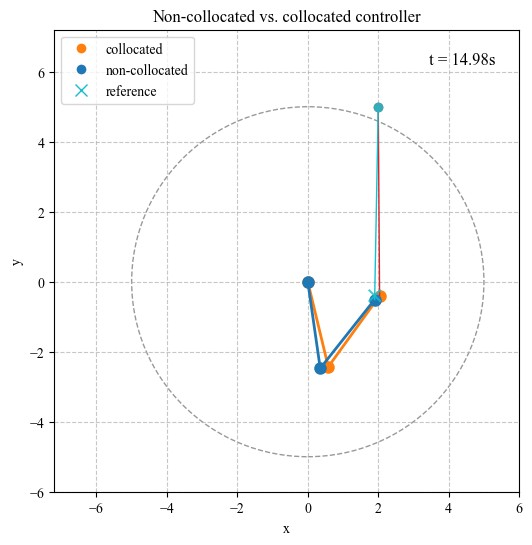

In [34]:
stride = 2
pos_end_qsim, pos_elbow_qsim = torch.vmap(transforms.forward_kinematics, in_dims=(None, 0))(rp, q_series_qsim[::stride])
#pos_end_thsim, pos_elbow_thsim = torch.vmap(transforms.forward_kinematics, in_dims=(None, 0))(rp, q_series_thsim[::stride])

frames_q_qsim = plotter.frame_pendulum(pos_end_qsim, pos_elbow_qsim)
#frames_q_thsim = plotter.frame_pendulum(pos_end_thsim, pos_elbow_thsim)

pos_end_collocated, pos_elbow_collocated = torch.vmap(transforms.forward_kinematics, in_dims=(None, 0))(rp, q_series_collocated[::stride])
frames_q_collocated = plotter.frame_pendulum(pos_end_collocated, pos_elbow_collocated)

data_qsim = {
	"frames": frames_q_qsim,
	"times": dt,
	"name": "non-collocated", 
	"arm_color": "tab:blue",
	"act_color": "tab:cyan"
}


data_collocated = {
	"frames": frames_q_collocated,
	"times": dt,
	"name": "collocated",
	"arm_color": "tab:orange", 
	"act_color": "tab:red"
} 


ref_pos_qsim = {
	"pos": xy_des_hat,
	"name": "reference",
	"color": "tab:cyan"
}

"""
ref_pos_thsim = {
	"pos": xy_des_hat,
	"name": "xysim",
	"color": "tab:orange"
}
"""

ref_poss = [ref_pos_qsim]#, ref_pos_thsim]#, ref_pos_est]#, ref_pos_naive]

frames_data = [data_collocated, data_qsim]#, data_thsim]#, data_est]

name_rp = "RP:(" + str(rp["xa"]) + "," + str(rp["ya"]) + ")_"
name_ref = "ref:(" + str(xy_des_real[0].item()) + "," + str(xy_des_real[1].item()) + ")_"

if neural_net:
	model_type = "NN"
else:
	model_type = "AL"

file_name = "t_end:[" + str(t_end) + "]_dt:[" + str(dt) + "]_stride:[" + str(stride) + "]_0.mp4"
file_counter = 0

output_path = os.path.join(save_dir, file_name)

while os.path.isfile(output_path):
	print("file name already exists")
	file_counter += 1
	file_name = file_name[:-6] + "_" + str(file_counter) + ".mp4"
	output_path = os.path.join(save_dir, file_name)

if neural_net == False:
	video_title = "Non-collocated controller, analytic coordinates"
else:
	video_title = "Non-collocated controller, learned coordinates"

video_title = "Non-collocated vs. collocated controller"


plotter.animate_pendulum(frames_data, video_title = video_title, ref_poss=ref_poss, plot_actuator=True, save_path=output_path, fps = 1/(dt*stride), dt = dt*stride)
#plotter.animate_pendulum(frames_data, ref_pos=None, plot_actuator=False, file_name=file_name, fps = 1/(dt*stride), dt = dt*stride)


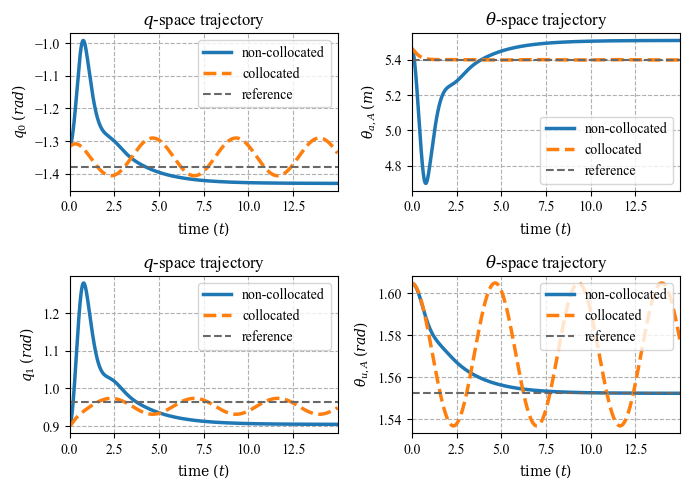

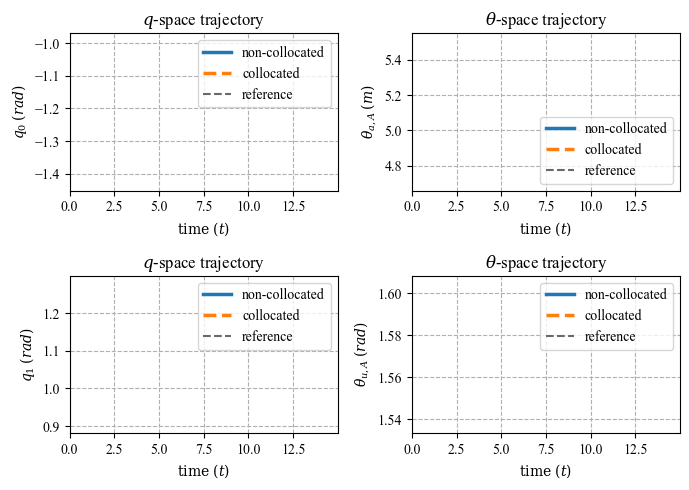

In [35]:
datasets_q = [
	{
		"name": "non-collocated",
		"values": q_series_qsim.cpu().detach().numpy(),
		"color": "tab:blue",
		"style": "solid"
	},
	{
		"name": "collocated",
		"values": q_series_collocated.cpu().detach().numpy(),
		"color": "tab:orange",
        "style": "dashed"
	}#,
	#{
	#    "name": "naive",
	#    "values": q_naive_series.cpu().detach().numpy(),
	#    "color": "tab:green"
	#}
]

datasets_th = [
	{
		"name": "non-collocated",
		"values": th_series_qsim.cpu().detach().numpy(),
		"color": "tab:blue",
		"style": "solid"
	},
	{
	    "name": "collocated",
	    "values": th_series_collocated.cpu().detach().numpy(),
	    "color": "tab:orange",
        "style": "dashed"
	}
]


datasets_xy = [
	{
		"name": "non-collocated",
		"values": xy_real_series_qsim.cpu().detach().numpy(),
		"color": "tab:orange",
		"style": "solid"
	},
	#{
	#	"name": "thsim",
	#	"values": xy_real_series_qsim.cpu().detach().numpy(),
	#	"color": "tab:blue"
	#}#,
	#{
	#    "name": "naive",
	#    "values": xy_naive_series.cpu().detach().numpy(),
	#    "color": "tab:green"
	#}
]

# Common labels for the plots.
name_q = r"${q}$" + "-space trajectory"
name_th = r"${\theta}$" + "-space trajectory"
name_xy = r"${(x,y)}$" + "-space trajectory"
t_series = torch.arange(0, t_end, dt)

# Create an instance of ErrorPlotter.
ep = pendulum_plot.Error_plotter_alt(rp)

# Prepare plot datasets for each column.
# Each call groups a set of datasets to be drawn in one subplot column.
column1 = ep.create_plot_dataset(t=t_series, datasets=datasets_q, reference=q_des, name=name_q)
column2 = ep.create_plot_dataset(t=t_series, datasets=datasets_th, reference=th_des, name=name_th)
column3 = ep.create_plot_dataset(t=t_series, datasets=datasets_xy, reference=xy_des_real.unsqueeze(0), name=name_xy)
plot_datasets = [column1, column2]#, column3]

file_name = "Error plot.png"
file_counter = 0

output_path = os.path.join(save_dir, file_name)

legend_locations = [["upper right", "lower right"], ["upper right", "upper right"]]

# Pass the list of columns (plot_dataset objects) to plot_multi.
ep.plot_multi(plot_datasets=plot_datasets, save_path=output_path, axes_names = [[r"$q_0$" + " " + r"$(rad)$", r"$q_1$" + " " + r"$(rad)$"], [r"$\theta_{a, A}$" + " " + r"$(m)$", r"$\theta_{u, A}$" + " " + r"$(rad)$"], [r"$x$", r"$y$"]], empty = False, legend_locations = legend_locations)
ep.plot_multi(plot_datasets=plot_datasets, save_path=output_path, axes_names = [[r"$q_0$" + " " + r"$(rad)$", r"$q_1$" + " " + r"$(rad)$"], [r"$\theta_{a, A}$" + " " + r"$(m)$", r"$\theta_{u, A}$" + " " + r"$(rad)$"], [r"$x$", r"$y$"]], empty = True, legend_locations = legend_locations)

### Sim in Y-space

In [ ]:


Y_series_Ysim = torch.empty((0,4)).to(device)
v_series_Ysim = torch.empty((0,1)).to(device)

Y = normal_form.calculate_Y(th_start, th_d_start, M_th_start, G_th_start, device)
#print(Y)
t_end = 15.
dt = 0.01

Y_A = torch.tensor([[0., 1., 0., 0.],
					[0., 0., 1., 0.],
					[0., 0., 0., 1.],
					[0., 0., 0., 0.]]).to(device)

Y_B = torch.tensor([[0.], [0.], [0.], [1.]]).to(device)



for t in torch.arange(0, t_end, dt):
	#print("t:", t.item())
	v = normal_form.calculate_v(Y, Y_des, K)

	Y_series_Ysim = torch.cat((Y_series_Ysim, Y.detach().T))
	Y_dot = Y_A @ Y + Y_B * v
	Y = Y + Y_dot * dt
	
	v_series_Ysim = torch.cat((v_series_Ysim, v.detach()))



In [ ]:
alphas_th_plot = torch.cat([alpha_beta_series_thsim[:, 0].unsqueeze(1), alpha_beta_true_series_thsim[:, 0].unsqueeze(1)], dim = 1)
betas_th_plot = torch.cat([alpha_beta_series_thsim[:, 1].unsqueeze(1), alpha_beta_true_series_thsim[:, 1].unsqueeze(1)], dim = 1)

alphas_q_plot = torch.cat([alpha_beta_series_qsim[:, 0].unsqueeze(1), alpha_beta_true_series_qsim[:, 0].unsqueeze(1)], dim = 1)
betas_q_plot = torch.cat([alpha_beta_series_qsim[:, 1].unsqueeze(1), alpha_beta_true_series_qsim[:, 1].unsqueeze(1)], dim = 1)

In [ ]:
show_thsim = False
show_Ysim = False
show_diff = False

if show_thsim:
	plot_quad_vs_time(Y_series_thsim[:500], dt, "Y_thsim", "Y_thsim vs time", ylim=(1.2, 1.4))
	plot_quad_vs_time(Y_series_thsim[:500], dt, "Y_thsim", "Y_thsim vs time", ylim=(-0.5, 0.5))
	plot_single_vs_time(v_series_thsim[:500], dt, "v_thsim", "v_thsim vs time", ylim=(-10, 10))
	#plot_single_vs_time(u_series_thsim[:500], dt, "u_thsim", "u_thsim vs time", ylim=(-50, 50))
	
	#plot_double_vs_time(th_series_thsim[:500], dt, "th_thsim", "th_thsim vs time")#, (1.5, 1.6))
	plot_double_vs_time(th_d_series_thsim[:500], dt, "th_d_thsim", "th_d_thsim vs time", (-2, 2))
	#plot_double_vs_time(th_dd_series_thsim[:500], dt, "th_dd_thsim", "th_dd_thsim vs time", (-10, 2))
	
	plot_single_vs_time(alpha_beta_series_thsim[:1000, 0], dt, "alpha", "alpha vs time")#, (-2, 10))
	plot_single_vs_time(alpha_beta_series_thsim[:1000, 1], dt, "beta", "beta vs time")#, (0.07, 0.14))
if show_Ysim:
	plot_quad_vs_time(Y_series_Ysim[:500], dt, "Y_Ysim", "Y_Ysim vs time", ylim=(1.2, 1.4))
	plot_quad_vs_time(Y_series_Ysim[:500], dt, "Y_Ysim", "Y_Ysim vs time", ylim=(-0.5, 0.5))
	plot_single_vs_time(v_series_Ysim[:500], dt, "v_Ysim", "v_Ysim vs time", ylim=(-10, 10))
	pass
if show_diff:
	plot_quad_vs_time(Y_series_thsim[:500] - Y_series_Ysim[:500], dt, "Y_diff", "Y_diff vs time")#, ylim=(-0.002, 0.002))
	plot_single_vs_time(v_series_thsim[:500] - v_series_Ysim[:500], dt, "v_diff", "v_diff vs time")#, ylim=(-0.1, 0.2))

Y_0sim_config = [
{"type": "quad", "data": Y_series_thsim[:500], "dt": dt, "ylabel": "Y_thsim", "title": "Y_thsim vs time", "ylim": (2, 4), "log": False},
{"type": "quad", "data": Y_series_qsim[:500], "dt": dt, "ylabel": "Y_qsim", "title": "Y_qsim vs time", "ylim": (2, 4), "log": False},
{"type": "quad", "data": Y_series_Ysim[:500], "dt": dt, "ylabel": "Y_Ysim", "title": "Y_Ysim vs time", "ylim": (2, 4), "log": False}
]

Y_123sim_config = [
{"type": "quad", "data": Y_series_thsim[:500], "dt": dt, "ylabel": "Y_thsim", "title": "Y_thsim vs time", "ylim": (-0.5, 0.5), "log": False},
{"type": "quad", "data": Y_series_qsim[:500], "dt": dt, "ylabel": "Y_qsim", "title": "Y_qsim vs time", "ylim": (-0.5, 0.5), "log": False},
{"type": "quad", "data": Y_series_Ysim[:500], "dt": dt, "ylabel": "Y_Ysim", "title": "Y_Ysim vs time", "ylim": (-0.5, 0.5), "log": False}
]

v_sim_config = [
{"type": "single", "data": v_series_thsim[:500], "dt": dt, "ylabel": "v_thsim", "title": "v_thsim vs time", "ylim": None, "log": False},
{"type": "single", "data": v_series_qsim[:500], "dt": dt, "ylabel": "v_qsim", "title": "v_qsim vs time", "ylim": None, "log": False},
{"type": "single", "data": v_series_Ysim[:500], "dt": dt, "ylabel": "v_Ysim", "title": "v_Ysim vs time", "ylim": None, "log": False}
]

th_thsim_config = [
{"type": "double", "data": th_series_thsim[:500], "dt": dt, "ylabel": "th_thsim", "title": "th_thsim vs time", "ylim": None, "log": False},
{"type": "double", "data": th_series_qsim[:500], "dt": dt, "ylabel": "th_qsim", "title": "th_qsim vs time", "ylim": None, "log": False}
]

th_d_sim_config = [
{"type": "double", "data": th_d_series_thsim[:500], "dt": dt, "ylabel": "th_d_thsim", "title": "th_d_thsim vs time", "ylim": None, "log": False},
{"type": "double", "data": th_d_series_qsim[:500], "dt": dt, "ylabel": "th_d_qsim", "title": "th_d_qsim vs time", "ylim": None, "log": False}
]

alpha_real_config = [
{"type": "double", "data": alphas_th_plot[:500], "dt": dt, "ylabel": "alpha_thsim", "title": "alpha_thsim vs time", "ylim": None, "log": False},
{"type": "double", "data": alphas_q_plot[:500], "dt": dt, "ylabel": "alpha_qsim", "title": "alpha_qsim vs time", "ylim": None, "log": False}
]

beta_real_config = [
{"type": "double", "data": betas_th_plot[:500], "dt": dt, "ylabel": "beta_thsim", "title": "beta_thsim vs time", "ylim": None, "log": False},
{"type": "double", "data": betas_q_plot[:500], "dt": dt, "ylabel": "beta_qsim", "title": "beta_qsim vs time", "ylim": None, "log": False}
]

u_real_config = [
{"type": "single", "data": u_series_thsim[:500], "dt": dt, "ylabel": "u_thsim", "title": "u_thsim vs time", "ylim": None, "log": False},
{"type": "single", "data": u_series_qsim[:500], "dt": dt, "ylabel": "u_qsim", "title": "u_qsim vs time", "ylim": None, "log": False}
]


print(alphas_th_plot.size())
plot_side_by_side(Y_0sim_config)
plot_side_by_side(Y_123sim_config)
plot_side_by_side(v_sim_config)
plot_side_by_side(th_thsim_config)
plot_side_by_side(alpha_real_config)
plot_side_by_side(beta_real_config)
plot_side_by_side(u_real_config)

#### Calculate Y as a function of $\theta_0$, with $\theta_1 = \bar{\theta}_{1}$

In [ ]:
plot_th_min, plot_th_max = 1, 9
th0_range = torch.linspace(plot_th_min, plot_th_max, 200).unsqueeze(1).to(device)
th1_range = (torch.ones(th0_range.size(0)).to(device) * th_des[0, 1]).unsqueeze(1)
th_des_range = torch.cat((th0_range, th1_range), dim=1)

y_plot_list = torch.empty(4,0).to(device)
G_th_1_list = torch.empty(0).to(device)

for th_des_plot in th_des_range:
	is_clockwise_des_plot = False
	
	th_des_plot = th_des_plot.unsqueeze(0)
	q_hat_des_plot = model.decoder_vmap(th_des_plot, is_clockwise_des_plot)
	q_d_hat_des_plot = (model.jacobian_dec(th_des_plot, clockwise=is_clockwise_des_plot) @ th_d_des.T).T

	J_h_inv_des = model.jacobian_dec(th_des_plot, is_clockwise_des_plot).squeeze(0)
	J_h_inv_trans_des = torch.transpose(J_h_inv_des, 0, 1)

	M_q_des, C_q_des, G_q_des = dynamics.dynamical_matrices(rp, q_hat_des_plot.squeeze(0), q_d_hat_des_plot.squeeze(0))
	G_q_des = dynamics.add_spring_force_G_q(rp, q_hat_des_plot, G_q_des, k_spring)
	
	M_th_des, C_th_des, G_th_des = transforms.transform_dynamical_from_inverse(M_q_des, C_q_des, G_q_des, th_des_plot, th_d_des, J_h_inv_des, J_h_inv_trans_des)
	
	
	Y_des = normal_form.calculate_Y(th_des_plot, th_d_des, M_th_des, G_th_des, device)
	y_plot_list = torch.cat((y_plot_list, Y_des), dim = -1)
	G_th_1_list = torch.cat((G_th_1_list, G_th_des[1]))



#### Plot the resulting Y as a function of $\theta_0$

In [ ]:
import math
from sympy import symbols, Eq, solve

# Circle parameters
r = rp["l0"] + rp["l1"]

# Points on the line
x1, y1 = xy_des_real[0].item(), xy_des_real[1].item()# 1.9219, -2.5157
x2, y2 = rp["xa"], rp["ya"]

# Line direction vector
dx = x2 - x1
dy = y2 - y1

# Parametric line: x = x1 + t*dx, y = y1 + t*dy
t = symbols('t')
x = x1 + t * dx
y = y1 + t * dy

# Equation of the circle: x^2 + y^2 = r^2
circle_eq = Eq(x**2 + y**2, r**2)

# Solve for t
solutions = solve(circle_eq, t)

# Find the coordinates of the intersection points
intersection_points = [(x1 + float(sol) * dx, y1 + float(sol) * dy) for sol in solutions]

# Calculate angle of the line with respect to horizontal in radians
angle_radians = math.atan2(dy, dx)

# Compute distances from point A to each intersection point
distances = [math.hypot(x2 - px, y2 - py) for px, py in intersection_points]

for i, distance in enumerate(distances):
	distances[i] = round(distance, 4)

short_distance = min(distances)
long_distance = max(distances)

rounded_points = []
for intersection in intersection_points:
	intx = round(intersection[0], 4)
	inty = round(intersection[1], 4)
	rounded_points.append((intx, inty))
	

print("Intersection points th1 and circle:", rounded_points)
print("Angle (th1) in radians:", round(angle_radians, 4))
print("Distances between intersection points and actuator point:\n", distances)


In [ ]:
plt.figure(figsize=(7, 3))
plt.plot(th0_range.squeeze(0).cpu().numpy(), y_plot_list[0].cpu().numpy(), label="y")
plt.plot(th0_range.squeeze(0).cpu().numpy(), y_plot_list[1].cpu().numpy(), label="y'")
plt.plot(th0_range.squeeze(0).cpu().numpy(), y_plot_list[2].cpu().numpy(), label="y''")
plt.plot(th0_range.squeeze(0).cpu().numpy(), y_plot_list[3].cpu().numpy(), label="y'''")
plt.xlabel("th0")
plt.ylabel("value")
plt.title("Y vs th0, for constant th1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(th0_range.squeeze(0).cpu().numpy(), G_th_1_list.detach().cpu().numpy())
plt.hlines(0, plot_th_min, plot_th_max, colors="k", linestyles="--")
vline_min = torch.min(torch.min((y_plot_list[i]), torch.tensor(-2))).cpu().numpy()
vline_max = torch.max(torch.max((y_plot_list[i]), torch.tensor(2))).cpu().numpy()
plt.vlines(0, vline_min, vline_max, colors="k", linestyles="--")
plt.vlines(short_distance, vline_min, vline_max, colors="r", linestyles="--")
plt.vlines(long_distance, vline_min, vline_max, colors="r", linestyles="--")

plt.title("G1 vs th0, for constant th1")
plt.xlim(0, 10)    
plt.ylim(-5, 5)
#plt.show()

#### Calculate $\alpha$, $\beta$ for varying $\{\theta_0, \theta_1, k_0, k_1\}$

In [ ]:
plot_th_0_min, plot_th_0_max = 1, 10
plot_th_1_min, plot_th_1_max = -1, 10

th_0_range = torch.linspace(plot_th_0_min, plot_th_0_max, 25).unsqueeze(1).to(device)
th_1_range = torch.linspace(plot_th_1_min, plot_th_1_max, 25).unsqueeze(1).to(device)

th_d_plot = torch.tensor([[1.], [1.]]).to(device).unsqueeze(0).requires_grad_()

k0_range = torch.tensor([[1.], [10.], [100.]]).to(device)
k1_range = torch.tensor([[1.], [10.], [100.]]).to(device)

#k0_range = torch.tensor([[-10.], [10.]]).to(device)
#k1_range = torch.tensor([[-10.], [10.]]).to(device)

k0_range = torch.tensor([[10.]]).to(device)
k1_range = torch.tensor([[10.]]).to(device)

alphas = torch.ones(len(k0_range), len(k1_range),
					 len(th_0_range),   len(th_1_range),
					 device='cpu')  # move final values to CPU for plotting)

betas = torch.ones(len(k0_range), len(k1_range),
					 len(th_0_range),   len(th_1_range),
					 device='cpu')  # move final values to CPU for plotting)

insides = torch.ones(len(k0_range), len(k1_range),
					 len(th_0_range),   len(th_1_range),
					 device='cpu')  # move final values to CPU for plotting)

In [ ]:



for k, th_0 in enumerate(th_0_range):
	for l, th_1 in enumerate(th_1_range):
		if l == 0:
			print("th_0:", th_0.item())

		is_clockwise_plot = False
		q_plot = transforms.analytic_inverse(rp, torch.tensor([th_0, th_1]))[0]
		th_plot = torch.cat((th_0, th_1), dim=0).unsqueeze(0).requires_grad_()
		

		q_hat_plot = model.decoder_vmap(th_plot, is_clockwise_plot)
		q_d_hat_plot = (model.jacobian_dec(th_plot, clockwise=is_clockwise_plot) @ th_d_plot.T).T

		J_h_inv_plot = model.jacobian_dec(th_plot, is_clockwise_plot).squeeze(0)
		J_h_inv_trans_plot = torch.transpose(J_h_inv_plot, 0, 1)

		M_q_plot, C_q_plot, G_q_plot = dynamics.dynamical_matrices(rp, q_hat_plot.squeeze(0), q_d_hat_plot.squeeze(0))
		A_q_plot = dynamics.input_matrix(rp, q_hat_plot.squeeze(0))

		for i, k0 in enumerate(k0_range):
			for j, k1 in enumerate(k1_range):
					
					k_spring_plot = [k0, k1]
					G_q_plot_spring = dynamics.add_spring_force_G_q(rp, q_hat_plot, G_q_plot.clone(), k_spring_plot)


					M_th_plot, C_th_plot, G_th_plot = transforms.transform_dynamical_from_inverse(M_q_plot, C_q_plot, G_q_plot_spring, th_plot,
																					  			th_d_plot, J_h_inv_plot, J_h_inv_trans_plot) 
					#G_th_plot = J_h_inv_trans_plot @ G_q_plot_spring
					#M_th_plot = torch.tensor([[rp["m1"], 0.], [0., rp["m1"]]]).to(device).requires_grad_(True)
					#M_th_plot = M_th_plot * th_plot/th_plot   
					A_th_plot = transforms.transform_input_matrix_from_inverse_trans(A_q_plot, J_h_inv_trans_plot)

					Y_plot = normal_form.calculate_Y(th_plot, th_d_plot, M_th_plot, G_th_plot, device)
					
					alpha, beta = normal_form.calculate_alpha_beta(th_plot, th_d_plot, M_th_plot, G_th_plot, A_th_plot, Y_plot)   
					alphas[i, j, k, l] = alpha.item()  
					betas[i, j, k, l] = beta.item()
					if torch.isnan(q_plot[0]):
						insides[i, j, k, l] = 0.


In [ ]:
th0_vals = th_0_range.squeeze().cpu()   # shape (3,)
th1_vals = th_1_range.squeeze().cpu()   # shape (3,)
from matplotlib.colors import TwoSlopeNorm

T0, T1 = torch.meshgrid(th0_vals, th1_vals, indexing='ij')

alphas_plot = torch.clamp(alphas, -1000, 1000)
betas_plot = torch.clamp(betas, -3, 3)

outputs = {
	"alphas": alphas_plot,
	"betas": betas_plot,
	#"insides": insides
}


n = len(outputs)



for i, k0 in enumerate(k0_range):
	for j, k1 in enumerate(k1_range):

		fig, axes = plt.subplots(1, n, figsize=(4*n,4))

		for (key, value), ax in zip(outputs.items(), axes):
			A_single = value[i, j]
			A_flat   = A_single.reshape(-1)  # flatten to (H*W,)
			Amax = A_flat.masked_fill(torch.isnan(A_flat), -float('inf')).max()
			Amin = A_flat.masked_fill(torch.isnan(A_flat), float('inf')).min()
			print("Amax:", Amax)
			print("Amin:", Amin)
			maxvalue = torch.max(torch.tensor([-Amin, Amax]))
			print("maxvalue:", maxvalue)
			if key == "alphass" or key == "betas":
				norm = TwoSlopeNorm(vmin=-maxvalue,
									vcenter=0,
									vmax=maxvalue)#A_flat.max())
				sc = ax.scatter(
					T0.reshape(-1),
					T1.reshape(-1),
					c=A_flat,
					s=100,
					cmap='Spectral',
					norm = norm
				)
			else:
				sc = ax.scatter(
					T0.reshape(-1),
					T1.reshape(-1),
					c=A_flat,
					s=100,
					cmap='Spectral',
					#norm = norm
				)				

			# make the plot
			
			

			# add colorbar
			cbar = fig.colorbar(sc, ax=ax)

			# labels & title
			ax.set_title(f"{key}, k0={k0.item()}, k1={k1.item()}")
			ax.set_xlabel("th0")
			ax.set_ylabel("th1")

		fig.tight_layout()
		plt.show()


### And now the same but for varying $\dot{\theta}$

In [ ]:
plot_th_0_min, plot_th_0_max = 3, 8
plot_th_1_min, plot_th_1_max = 0, 4

th_0_range = torch.linspace(plot_th_0_min, plot_th_0_max, 10).unsqueeze(1).to(device)
th_1_range = torch.linspace(plot_th_1_min, plot_th_1_max, 10).unsqueeze(1).to(device)

k_spring_plot = torch.tensor(k_spring).to(device)
k_spring_plot = torch.tensor([4., 4.]).to(device)
#rest_angles_plot = torch.tensor(rest_angles).to(device)

print(k_spring_plot)
#print(rest_angles_plot)

rest_angle_0_range = torch.linspace(0., 0.1 * torch.pi, 1).unsqueeze(1).to(device)
rest_angle_1_range = torch.linspace(0., torch.pi, 10).unsqueeze(1).to(device)
print(rest_angle_0_range)


th_d_plot = torch.tensor([[0., 0.]]).to(device)

alphas = torch.ones(len(rest_angle_0_range), len(rest_angle_1_range),
					 len(th_0_range),   len(th_1_range),
					 device='cpu')  # move final values to CPU for plotting)

betas = torch.ones(len(rest_angle_0_range), len(rest_angle_1_range),
					 len(th_0_range),   len(th_1_range),
					 device='cpu')  # move final values to CPU for plotting)

insides = torch.ones(len(rest_angle_0_range), len(rest_angle_1_range),
					 len(th_0_range),   len(th_1_range),
					 device='cpu')  # move final values to CPU for plotting)

Y2s = torch.ones(len(rest_angle_0_range), len(rest_angle_1_range),
					 len(th_0_range),   len(th_1_range),
					 device='cpu')  # move final values to CPU for plotting)
 

In [ ]:



for k, th_0 in enumerate(th_0_range):
	for l, th_1 in enumerate(th_1_range):
		for i, ra_0 in enumerate(rest_angle_0_range):
			for j, ra_1 in enumerate(rest_angle_1_range):
					
				
				if l == 0 and i == 0 and j == 0:
					print("th_0:", th_0.item())

				is_clockwise_plot = False
				q_plot = transforms.analytic_inverse(rp, torch.tensor([th_0, th_1]))[0]
				th_plot = torch.cat((th_0, th_1), dim=0).unsqueeze(0).requires_grad_()
				
				rest_angles_plot = torch.tensor([ra_0, ra_1]).to(device)

				q_hat_plot = model.decoder_vmap(th_plot, is_clockwise_plot)
				q_d_hat_plot = (model.jacobian_dec(th_plot, clockwise=is_clockwise_plot) @ th_d_plot.T).T

				J_h_inv_plot = model.jacobian_dec(th_plot, is_clockwise_plot).squeeze(0)
				J_h_inv_trans_plot = torch.transpose(J_h_inv_plot, 0, 1)

				M_q_plot, C_q_plot, G_q_plot = dynamics.dynamical_matrices(rp, q_hat_plot.squeeze(0), q_d_hat_plot.squeeze(0))
				A_q_plot = dynamics.input_matrix(rp, q_hat_plot.squeeze(0))					
				
				G_q_plot_spring = dynamics.add_spring_force_G_q(rp, q_hat_plot, G_q_plot.clone(), k_spring_plot, rest_angles_plot)
				M_th_plot, C_th_plot, G_th_plot = transforms.transform_dynamical_from_inverse(M_q_plot, C_q_plot, G_q_plot_spring, th_plot,
																				  			th_d_plot, J_h_inv_plot, J_h_inv_trans_plot) 
				A_th_plot = transforms.transform_input_matrix_from_inverse_trans(A_q_plot, J_h_inv_trans_plot)

				Y_plot = normal_form.calculate_Y(th_plot, th_d_plot, M_th_plot, G_th_plot, device)
				Y2s[i, j, k, l] = Y_plot[2].item()
				
				alpha, beta = normal_form.calculate_alpha_beta(th_plot, th_d_plot, M_th_plot, G_th_plot, A_th_plot, Y_plot)   
				alphas[i, j, k, l] = alpha.item()  
				betas[i, j, k, l] = beta.item()
				if torch.isnan(q_plot[0]):
					insides[i, j, k, l] = 0.


In [ ]:
th0_vals = th_0_range.squeeze().cpu()   # shape (3,)
th1_vals = th_1_range.squeeze().cpu()   # shape (3,)
from matplotlib.colors import TwoSlopeNorm

T0, T1 = torch.meshgrid(th0_vals, th1_vals, indexing='ij')

alphas_plot = torch.clamp(alphas, -3000, 3000)
betas_plot = torch.clamp(betas, -3, 3)
Y2s_plot = torch.clamp(Y2s, -3, 3)

outputs = {
	"alphas": alphas_plot,
	"betas": betas_plot,
	#"insides": insides
	"Y2_plots": Y2s_plot
}


n = len(outputs)



for i, ra_0 in enumerate(rest_angle_0_range):
	for j, ra_1 in enumerate(rest_angle_1_range):

		fig, axes = plt.subplots(1, n, figsize=(2.6*n,2.6))

		for (key, value), ax in zip(outputs.items(), axes):
			A_single = value[i, j]
			A_flat   = A_single.reshape(-1)  # flatten to (H*W,)
			Amax = A_flat.masked_fill(torch.isnan(A_flat), -float('inf')).max()
			Amin = A_flat.masked_fill(torch.isnan(A_flat), float('inf')).min()
			maxvalue = torch.max(torch.tensor([-Amin/5, Amax/5]))
			if key == "Y2_plots":
				maxvalue = torch.max(torch.tensor([-Amin, Amax]))
			if key == "alphas" or key == "betas":# or key == "Y2_plots":
				norm = TwoSlopeNorm(vmin=-maxvalue,
									vcenter=0,
									vmax=maxvalue)#A_flat.max())
				sc = ax.scatter(
					T0.reshape(-1),
					T1.reshape(-1),
					c=A_flat,
					s=100,
					cmap='Spectral',
					norm = norm
				)
			else:
				sc = ax.scatter(
					T0.reshape(-1),
					T1.reshape(-1),
					c=A_flat,
					s=100,
					cmap='Spectral',
					#norm = norm
				)				

			# make the plot
			
			

			# add colorbar
			cbar = fig.colorbar(sc, ax=ax)

			# labels & title
			ax.set_title(f"{key}, offset0={round(ra_0.item(), 3)}, offset1={round(ra_1.item(), 3)}")
			ax.set_xlabel("th0")
			ax.set_ylabel("th1")

		fig.tight_layout()
		plt.show()



In [ ]:
import numpy as np
print(np.nanargmin(torch.abs(Y2s_plot)))

flat_idx = np.nanargmin(torch.abs(Y2s_plot))   # this is a single scalar index into the flattened tensor

# 2) convert to numpy and unravel
flat_idx = flat_idx
d0, d1, i0, i1 = np.unravel_index(flat_idx, Y2s.shape)

print("indices (th_d_0_idx, th_d_1_idx, th0_idx, th1_idx):", d0, d1, i0, i1)
print("minimum abs value:", Y2s_plot[d0, d1, i0, i1].item())

